# Protein data acquisition: Protein Data Bank (PDB)

Developed in the CADD seminars 2017 and 2018, Volkamer lab, Charité/FU Berlin 

Authors:

- Anja Georgi
- Majid Vafadar
- Jaime Rodríguez-Guerra, Volkamer lab, Charité
- Dominique Sydow, Volkamer lab, Charité

__Talktorial T8__: This talktorial is part of the TeachOpenCADD pipeline described in the [first TeachOpenCADD paper](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x), comprising of talktorials T1-T10.

## Aim of this talktorial

In this talktorial, we conduct the groundwork for the next talktorial where we will generate a ligand-based ensemble pharmacophore for EGFR. Therefore, we 
(i) fetch all PDB IDs for EGFR from the PDB database, 
(ii) retrieve five protein-ligand structures, which have the best structural quality and are derived from X-ray crystallography, and 
(iii) align all structures to each in 3D as well as extract and save the ligands to be used in the next talktorial.

## Learning Goals

### Theory
* Protein Data Bank (PDB)
* Python package `pypdb`
 
### Practical

* Select query protein
* Get statistic on PDB entries for query protein
* Get all PDB IDs for query protein
* Get meta information on PDB entries
* Filter and sort meta information on PDB entries
* Get meta information of ligands from top structures
* Draw top ligand molecules
* Create protein-ligand ID pairs
* Get the PDB structure files
* Align PDB structures

## References

* Protein Data Bank 
([PDB website](http://www.rcsb.org/pdb>))
* `pypdb` python package 
([<i>Bioinformatics</i> (2016), <b>32</b>, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543))
* `pypdb` python package documentation 
([`pypdb` website](http://www.wgilpin.com/pypdb_docs/html/))
* Molecular superposition with Python: [`opencadd`](https://github.com/volkamerlab/opencadd) (`structure.superposition` module)

## Theory

### Protein Data Bank (PDB)

The Protein Data Bank (PDB) is one of the most comprehensive structural biology information databases and a key resource in areas of structural biology, such as structural genomics and drug design. ([PDB website](http://www.rcsb.org/pdb>))

Structural data is generated from structural determination methods such as X-ray crystallography (most common method), nuclear magnetic resonance (NMR), and cryo electron microscopy (cryo-EM). 
For each entry, the database contains (i) the 3D coordinates of the atoms and the bonds connecting these atoms for proteins, ligand, cofactors, water molecules, and ions, as well as (ii) meta information on the structural data such as the PDB ID, the authors, the deposition date, the structural determination method used and the structural resolution.

The structural resolution is a measure of the quality of the data that has been collected and has the unit Å (Angström). The lower the value, the higher the quality of the structure. 

The PDB website offers the 3D visualization of the protein structures (with ligand interactions if available) and the structure quality metrics, as can be seen for the PDB entry of an example epidermal growth factor receptor (EGFR) with the [PDB ID 3UG5](https://www.rcsb.org/structure/3UG5).

<img src="./images/protein-ligand-complex.png" align="above" alt="Image cannot be shown" width="400">
<div align="center"> Figure 1: The protein structure (in gray) with an interacting ligand (in green) is shown for an example epidermal growth factor receptor (EGFR) with the PDB ID 3UG5 (figure by Dominique Sydow).</div>

### Python package `pypdb`

`pypdb` is a python programming interface for the PDB and works exclusively in Python 3. 
This package facilitates the integration of automatic PDB searches within bioinformatics workflows and simplifies the process of performing multiple searches based on the results of existing searches. 
It also allows an advanced querying of information on PDB entries. 
The PDB currently uses a RESTful API that allows for the retrieval of information via standard HTML vocabulary. `pypdb` converts these objects into XML strings. 
([<i>Bioinformatics</i> (2016), <b>32</b>, 159-60](https://academic.oup.com/bioinformatics/article-lookup/doi/10.1093/bioinformatics/btv543))

A list of functions is provided on the `pypdb` documentation website ([`pypdb` website](http://www.wgilpin.com/pypdb_docs/html/)).

## Practical

In [1]:
import collections
import glob
import logging
import time

from tqdm import tqdm
import matplotlib.pyplot as plt
import nglview
import numpy as np
import pandas as pd
import pypdb
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
import redo

from opencadd.structure.superposition.api import align, METHODS
from opencadd.structure.core import Structure

# Disable some unneeded warnings
logger = logging.getLogger("opencadd")
logger.setLevel(logging.ERROR)

%matplotlib inline
IPythonConsole.ipython_useSVG=True

### Select query protein

We use EGFR as query protein for this talktorial. The UniProt ID of EGFR is `P00533`, which will be used in the following to query the PDB database.

### Get statistic on PDB entries for query protein 

First, we ask the question: How many PDB entries are deposited in the PDB for EGFR per year and how many in total?

We can do a search on the [PDB website](http://www.rcsb.org) with the search term `P00533`. 
As of September 2020, the PDB returned 179 search results.

Using `pypdb`, we can find all deposition dates of EGFR structures from the PDB database. The number of deposited structures is needed to set the parameter `max_results` of the function `find_dates`.

In [2]:
# Note: Parameter max_results default is 100, which is too low for EGFR
# If max_results > maximal number of EGFR structures: error, 
# Therefore we checked beforehand how many results exist (#179)

# This database query may take a moment (minute to couple of minutes)
all_dates = pypdb.find_dates("P00533", max_results=179)  

In [3]:
print("Number of EGFR structures found: ", len(all_dates))

Number of EGFR structures found:  179


In [4]:
# Example of the first three deposition dates
all_dates[:3]

['2002-03-28', '2002-06-17', '2002-06-17']

We extract the year from the deposition dates and calculate a depositions-per-year histogram.

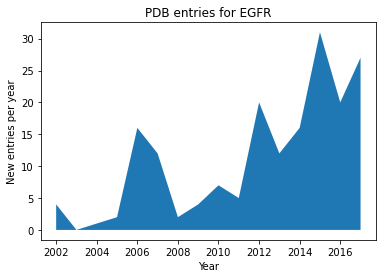

In [5]:
# Extract year
all_dates = np.asarray(all_dates)
all_years = np.asarray([int(depdate[:4]) for depdate in all_dates])

# Calculate histogram
bins = max(all_years)-min(all_years)  # Bin number = year range
subs_v_time = np.histogram(all_years, bins)

# All entries (excluding 2018) are plotted
dates, num_entries = subs_v_time[1][:-1], subs_v_time[0]  

# Show histogram
fig, ax = plt.subplots()
ax.fill_between(dates, 0, num_entries)
ax.set_ylabel("New entries per year")
ax.set_xlabel("Year")
ax.set_title("PDB entries for EGFR")
plt.show()

### Get all PDB IDs for query protein

Now, we get all PDB structures for our query protein EGFR, using the `pypdb` function `make_query` and `do_search`.

In [6]:
search_dict = pypdb.make_query("P00533")  # May run into timeout when max_results is 180 or more
found_pdb_ids = pypdb.do_search(search_dict)

print("PDB IDs found for query:", *found_pdb_ids)

print("Number of structures:", len(found_pdb_ids))

PDB IDs found for query: 1IVO 1M14 1M17 1MOX 1XKK 1YY9 1Z9I 2EB2 2EB3 2GS2 2GS7 2ITN 2ITO 2ITP 2ITQ 2ITT 2ITU 2ITV 2ITW 2ITX 2ITY 2ITZ 2J5E 2J5F 2J6M 2JIT 2JIU 2JIV 2KS1 2M0B 2M20 2N5S 2RF9 2RFD 2RFE 2RGP 3B2U 3B2V 3BEL 3BUO 3C09 3GOP 3GT8 3IKA 3LZB 3NJP 3OB2 3OP0 3P0Y 3PFV 3POZ 3QWQ 3UG1 3UG2 3VJN 3VJO 3VRP 3VRR 3W2O 3W2P 3W2Q 3W2R 3W2S 3W32 3W33 4G5J 4G5P 4HJO 4I1Z 4I20 4I21 4I22 4I23 4I24 4JQ7 4JQ8 4JR3 4JRV 4KRL 4KRM 4KRO 4KRP 4LI5 4LL0 4LQM 4LRM 4R3P 4R3R 4R5S 4RIW 4RIX 4RIY 4RJ4 4RJ5 4RJ6 4RJ7 4RJ8 4TKS 4UIP 4UV7 4WD5 4WKQ 4WRG 4ZAU 4ZJV 4ZSE 5C8K 5C8M 5C8N 5CAL 5CAN 5CAO 5CAP 5CAQ 5CAS 5CAU 5CAV 5CNN 5CNO 5CZH 5CZI 5D41 5EDP 5EDQ 5EDR 5EM5 5EM6 5EM7 5EM8 5FED 5FEE 5FEQ 5GMP 5GNK 5GTY 5GTZ 5HCX 5HCY 5HCZ 5HG5 5HG7 5HG8 5HG9 5HIB 5HIC 5J9Y 5J9Z 5JEB 5LV6 5SX4 5SX5 5U8L 5UG8 5UG9 5UGA 5UGB 5UGC 5UWD 5WB7 5WB8 5X26 5X27 5X28 5X2A 5X2C 5X2F 5X2K 5XDK 5XDL 5XGM 5XGN 5XWD 5Y25 5Y9T 5YU9 5ZTO 5ZWJ 6ARU 6B3S 6D8E 6DUK 6JRJ 6JRK 6JRX 6JWL 6JX0 6JX4 6JXT 6JZ0 6P1D 6P1L 6P8Q 6S89 6S8A 6S9B 

### Get meta information for PDB entries

We use `describe_pdb` to get meta information about the structures, which is stored per structure as a dictionary. These are long queries that might fail here and there due to connection errors, so we try a number of times before giving up.

Note: we only fetch meta information on PDB structures here, we do not fetch the structures (3D coordinates), yet.

In [7]:
@redo.retriable(attempts=10, sleeptime=2)
def describe_one_pdb_id(pdb_id):
    described = pypdb.describe_pdb(i)
    if described is None:
        print(f"! Error while fetching {pdb_id}, retrying...")
        raise ValueError(f"Could not fetch PDB id {pdb_id}")
    return described

# This database query may take a moment
pdbs = []
for i in found_pdb_ids:
    pdbs.append(describe_one_pdb_id(i))

pdbs[0]

{'relatedPDB': {'@pdbId': '1JL9',
  '@details': '1JL9 contains dymeric human EGF molecules.'},
 'structureId': '1IVO',
 'title': 'Crystal Structure of the Complex of Human Epidermal Growth Factor and Receptor Extracellular Domains.',
 'pubmedId': '12297050',
 'expMethod': 'X-RAY DIFFRACTION',
 'resolution': '3.30',
 'keywords': 'TRANSFERASE/SIGNALING PROTEIN',
 'nr_entities': '2',
 'nr_residues': '1350',
 'nr_atoms': '8813',
 'deposition_date': '2002-03-28',
 'release_date': '2002-10-16',
 'last_modification_date': '2020-07-29',
 'structure_authors': 'Ogiso, H., Ishitani, R., Nureki, O., Fukai, S., Yamanaka, M., Kim, J.H., Saito, K., Shirouzu, M., Yokoyama, S., RIKEN Structural Genomics/Proteomics Initiative (RSGI)',
 'citation_authors': 'Ogiso, H., Ishitani, R., Nureki, O., Fukai, S., Yamanaka, M., Kim, J.H., Saito, K., Inoue, M., Shirouzu, M., Yokoyama, S.',
 'status': 'CURRENT'}

### Filter and sort meta information on PDB entries

Since we want to use the information to filter for relevant PDB structures, we convert the data set from dictionary to DataFrame for easier handling.

In [9]:
pdbs = pd.DataFrame(pdbs)
pdbs.head()

,relatedPDB,structureId,title,pubmedId,expMethod,resolution,keywords,nr_entities,nr_residues,nr_atoms,deposition_date,release_date,last_modification_date,structure_authors,citation_authors,status,pubmedCentralId
0,"{'@pdbId': '1JL9', '@details': '1JL9 contains ...",1IVO,Crystal Structure of the Complex of Human Epid...,12297050,X-RAY DIFFRACTION,3.30,TRANSFERASE/SIGNALING PROTEIN,2,1350,8813,2002-03-28,2002-10-16,2020-07-29,"Ogiso, H., Ishitani, R., Nureki, O., Fukai, S....","Ogiso, H., Ishitani, R., Nureki, O., Fukai, S....",CURRENT,NaN
1,"{'@pdbId': '1M17', '@details': 'Epidermal Grow...",1M14,Tyrosine Kinase Domain from Epidermal Growth F...,12196540,X-RAY DIFFRACTION,2.60,TRANSFERASE,1,333,2452,2002-06-17,2002-09-04,2011-07-13,"Stamos, J., Sliwkowski, M.X., Eigenbrot, C.","Stamos, J., Sliwkowski, M.X., Eigenbrot, C.",CURRENT,NaN
2,"{'@pdbId': '1M14', '@details': 'Apo-form Epide...",1M17,Epidermal Growth Factor Receptor tyrosine kina...,12196540,X-RAY DIFFRACTION,2.60,TRANSFERASE,1,333,2540,2002-06-17,2002-09-04,2011-07-13,"Stamos, J., Sliwkowski, M.X., Eigenbrot, C.","Stamos, J., Sliwkowski, M.X., Eigenbrot, C.",CURRENT,NaN
3,"[{'@pdbId': '1IGR', '@details': '1IGR contains...",1MOX,Crystal Structure of Human Epidermal Growth Fa...,12297049,X-RAY DIFFRACTION,2.50,transferase/growth factor,2,1102,8607,2002-09-10,2003-09-10,2020-07-29,"Garrett, T.P.J., McKern, N.M., Lou, M., Ellema...","Garrett, T.P.J., McKern, N.M., Lou, M., Ellema...",CURRENT,NaN
4,NaN,1XKK,EGFR kinase domain complexed with a quinazolin...,15374980,X-RAY DIFFRACTION,2.40,TRANSFERASE,1,352,2299,2004-09-29,2004-12-07,2011-07-13,"Wood, E.R., Truesdale, A.T., McDonald, O.B., Y...","Wood, E.R., Truesdale, A.T., McDonald, O.B., Y...",CURRENT,NaN


In [10]:
print(f"Number of PDB structures for EGFR: {len(pdbs)}")

Number of PDB structures for EGFR: 205


We start filtering our dataset based on the following criteria:

#### 1. Experimental method: X-ray diffraction

We only keep structures resolved by `X-RAY DIFFRACTION`, the most commonly used structure determination method. 

In [11]:
pdbs = pdbs[pdbs.expMethod =="X-RAY DIFFRACTION"]
print(f"Number of PDB structures for EGFR from X-ray: {len(pdbs)}")

Number of PDB structures for EGFR from X-ray: 199


#### 2. Structural resolution

We only keep structures with a resolution equal or lower than 3 Å (Angström). The lower the resolution value, the higher is the quality of the structure (= the higher is the certainty that the assigned 3D coordinates of the atoms are correct). Below 3 Å, atomic orientations can be determined  and therefore is often used as threshold for structures relevant for structure-based drug design.

In [12]:
pdbs_resolution = [float(i) for i in pdbs.resolution.tolist()]
pdbs = pdbs[[i <= 3.0 for i in pdbs_resolution]]

print(f"Number of PDB structures for EGFR from X-ray with resolution <= 3.0 Angström: {len(pdbs)}")

Number of PDB structures for EGFR from X-ray with resolution <= 3.0 Angström: 164


We sort the data set by the structural resolution. 

In [13]:
pdbs = pdbs.sort_values(["resolution"], 
                        ascending=True, 
                        na_position='last')

We check the top PDB structures (sorted by resolution): 

In [14]:
pdbs.head()[["structureId", "resolution"]]

,structureId,resolution
153,5UG9,1.33
141,5HG8,1.42
152,5UG8,1.46
50,3POZ,1.50
56,3VRP,1.52


#### 3. Ligand-bound structures

Since we will create ensemble ligand-based pharmacophores in the next talktorial, we remove all PDB structures from our DataFrame, which do not contain a bound ligand: we use the `pypdb` function `get_ligands` to check/retrieve the ligand(s) from a PDB structure. PDB-annotated ligands can be ligands, cofactors, but also solvents and ions. In order to filter only ligand-bound structures, we (i) remove all structures without any annotated ligand and (ii) remove all structures that do not contain any ligands with a molecular weight (MW) greater than 100 Da (Dalton), since many solvents and ions weight less. Note: this is a simple, but not comprehensive exclusion of solvents and ions. 

In [15]:
# Get all PDB IDs from DataFrame
pdb_ids = pdbs["structureId"].values.tolist()

In [17]:
# Remove structures 
# (i) without ligand and 
# (ii) without any ligands with molecular weight (MW) greater than 100 Da (Dalton)

@redo.retriable(attempts=10, sleeptime=2)
def get_ligands(pdb_id):
    """Decorate pypdb.get_ligands so it retries after a failure"""
    return pypdb.get_ligands(pdb_id)

mw_cutoff = 100.0  # Molecular weight cutoff in Da

# This database query may take a moment
removed_pdb_ids = []
progressbar =  tqdm(pdb_ids, desc="Processing...")
for i in progressbar:
    progressbar.set_description(f"Processing {i}...")
    ligand_dict = get_ligands(i)
            
    # (i) Remove structure if no ligand present
    if ligand_dict["ligandInfo"] is None:
        pdb_ids.remove(i) # Remove ligand-free PDB IDs from list
        removed_pdb_ids.append(i) # Store ligand-free PDB IDs

    # (ii) Remove structure if not a single annotated ligand has a MW above mw_cutoff
    else:
        # Get ligand information
        ligs = ligand_dict["ligandInfo"]["ligand"]
        # Technicality: if only one ligand, cast dict to list (for the subsequent list comprehension)
        if type(ligs) == dict:
            ligs = [ligs]
        # Get MW per annotated ligand
        mw_list = [float(i["@molecularWeight"]) for i in ligs]
        # Remove structure if not a single annotated ligand has a MW above mw_cutoff
        if sum([mw > mw_cutoff for mw in mw_list]) == 0:
            pdb_ids.remove(i) # Remove ligand-free PDB IDs from list
            removed_pdb_ids.append(i) # Store ligand-free PDB IDs

print("PDB structures without a ligand (removed from our data set):", *removed_pdb_ids)

Processing 5XGN...:  99%|█████████▊| 155/157 [00:43<00:00,  3.57it/s]

PDB structures without a ligand (removed from our data set): 3GOP 5EDP


In [18]:
print(f"Number of structures with ligand: {len(pdb_ids)}")

Number of structures with ligand: 155


### Get meta information of ligands from top structures

In the next talktorial, we will build ligand-based ensemble pharmacophores from the top `top_num` structures with the highest resolution.

In [19]:
top_num = 4  # Number of top structures
pdb_ids = pdb_ids[:top_num]
pdb_ids

['5UG9', '5HG8', '5UG8', '3POZ']

We fetch the PDB information about the top `top_num` ligands using `get_ligands`, to be stored as *csv* file (as dictionary per ligand).

If a structure contains several ligands, we select the largest ligand. Note: this is a simple, but not comprehensive method to select ligand binding the binding site of a protein. This approach may also select a cofactor bound to the protein. Therefore, please check the automatically selected top ligands visually before further usage.

In [20]:
ligands_list = []

for i in pdb_ids:
    progressbar.set_description(f"Processing {i}...")
    ligands = get_ligands(i)["ligandInfo"]["ligand"]
    
    # Technicality: if only one ligand, cast dict to list (for the subsequent list comprehension)
    if isinstance(ligands, dict):
        ligands = [ligands]

    weight = 0
    this_lig = {}
    
    # If several ligands contained, take largest
    for lig in ligands:
        if float(lig["@molecularWeight"]) > weight:
            this_lig = lig
            weight = float(lig["@molecularWeight"])
            
    ligands_list.append(this_lig)

# Change the format to DataFrame
ligs = pd.DataFrame(ligands_list)
ligs

,@structureId,@chemicalID,@type,@molecularWeight,chemicalName,formula,InChI,InChIKey,smiles
0,5UG9,8AM,non-polymer,445.494,"N-[(3R,4R)-4-fluoro-1-{6-[(3-methoxy-1-methyl-...",C20 H28 F N9 O2,InChI=1S/C20H28FN9O2/c1-6-15(31)23-13-9-29(7-1...,MJLFLAORJNTNDV-CHWSQXEVSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
1,5HG8,634,non-polymer,377.4,N-[3-({2-[(1-methyl-1H-pyrazol-4-yl)amino]-7H-...,C19 H19 N7 O2,InChI=1S/C19H19N7O2/c1-3-16(27)22-12-5-4-6-14(...,YWNHZBNRKJYHTR-UHFFFAOYSA-N,CCC(=O)Nc1cccc(c1)Oc2c3cc[nH]c3nc(n2)Nc4cnn(c4)C
2,5UG8,8BP,non-polymer,415.468,"N-[(3R,4R)-4-fluoro-1-{6-[(1-methyl-1H-pyrazol...",C19 H26 F N9 O,InChI=1S/C19H26FN9O/c1-5-15(30)24-14-9-28(8-13...,CGULPICMFDDQRH-ZIAGYGMSSA-N,CCC(=O)N[C@@H]1CN(C[C@H]1F)c2nc(c3c(n2)n(cn3)C...
3,3POZ,03P,non-polymer,547.957,N-{2-[4-({3-chloro-4-[3-(trifluoromethyl)pheno...,C26 H25 Cl F3 N5 O3,"InChI=1S/C26H25ClF3N5O3/c1-25(2,37)14-22(36)31...",ZYQXEVJIFYIBHZ-UHFFFAOYSA-N,CC(C)(CC(=O)NCCn1ccc2c1c(ncn2)Nc3ccc(c(c3)Cl)O...


In [21]:
ligs.to_csv("data/PDB_top_ligands.csv", header=True, index=False, sep="\t")

### Draw top ligand molecules

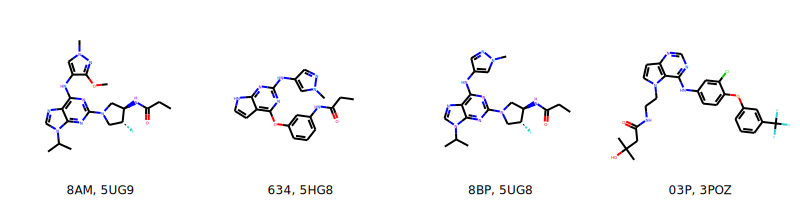

In [22]:
PandasTools.AddMoleculeColumnToFrame(ligs, "smiles")
Draw.MolsToGridImage(
    mols=list(ligs.ROMol), 
    legends=list(ligs["@chemicalID"]+', '+ligs["@structureId"]), 
    molsPerRow=top_num
)

### Create protein-ligand ID pairs

In [23]:
pairs = collections.OrderedDict()

for idx, row in ligs.iterrows():
    pairs[str(row["@structureId"])] = str(row["@chemicalID"])

print(pairs)

OrderedDict([('5UG9', '8AM'), ('5HG8', '634'), ('5UG8', '8BP'), ('3POZ', '03P')])


### Align PDB structures

Since we want to build ligand-based ensemble pharmacophores in the next talktorial, it is necessary to align all structures to each other in 3D. 

We will use one of our packages, [`opencadd`](https://github.com/volkamerlab/opencadd), which includes a 3D superposition subpackage  to guide the structural alignment of the proteins. The approach is based on superposition guided by sequence alignment provided matched residues. There are other methods in the package, but this simple one will be enough for the task at hand.

#### 1. Get the PDB structure files

We now fetch the PDB structure files, i.e. 3D coordinates of the protein, ligand (and if available other atomic or molecular entities such as cofactors, water molecules, and ions) from the PDB using `opencadd.structure.superposition`. 

Available file formats are *pdb* and *cif*, which store the 3D coordinations of atoms of the protein (and ligand, cofactors, water molecules, and ions) as well as information on bonds between atoms. Here, we work with *pdb* files.

In [24]:
# Recap: PDB structures of interest
list(pairs.items())

[('5UG9', '8AM'), ('5HG8', '634'), ('5UG8', '8BP'), ('3POZ', '03P')]

In [25]:
# Download PDB structures
structures = [Structure.from_pdbid(pdb_id) for pdb_id in pairs]
structures

[<Universe with 2664 atoms>,
 <Universe with 2716 atoms>,
 <Universe with 2632 atoms>,
 <Universe with 2536 atoms>]

#### 2. Extract protein and ligand

Extract protein and ligand from the structure in order to remove solvent and other artifacts of crystallography.

In [26]:
complexes = [Structure.from_atomgroup(structure.select_atoms(f"protein or resname {ligand}")) for structure, ligand in zip(structures, pairs.values())]
complexes

/home/jaime/.conda/envs/teachopencadd-ci/lib/python3.8/site-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(sorted(unique_bonds)), 4)


[<Universe with 2330 atoms>,
 <Universe with 2491 atoms>,
 <Universe with 2319 atoms>,
 <Universe with 2395 atoms>]

In [27]:
# Write complex to file
for complex_, pdb_id in zip(complexes, pairs.keys()):
    complex_.write(f"./data/{pdb_id}.pdb")

/home/jaime/.conda/envs/teachopencadd-ci/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/jaime/.conda/envs/teachopencadd-ci/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1026: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"


#### 3. Align proteins

Align complexes (based on protein atoms).

In [28]:
results = align(complexes, method=METHODS["mda"])

In [29]:
v = nglview.NGLWidget()
for complex_ in complexes:
    v.add_component(complex_.atoms)
v

NGLWidget()

In [30]:
v.render_image();

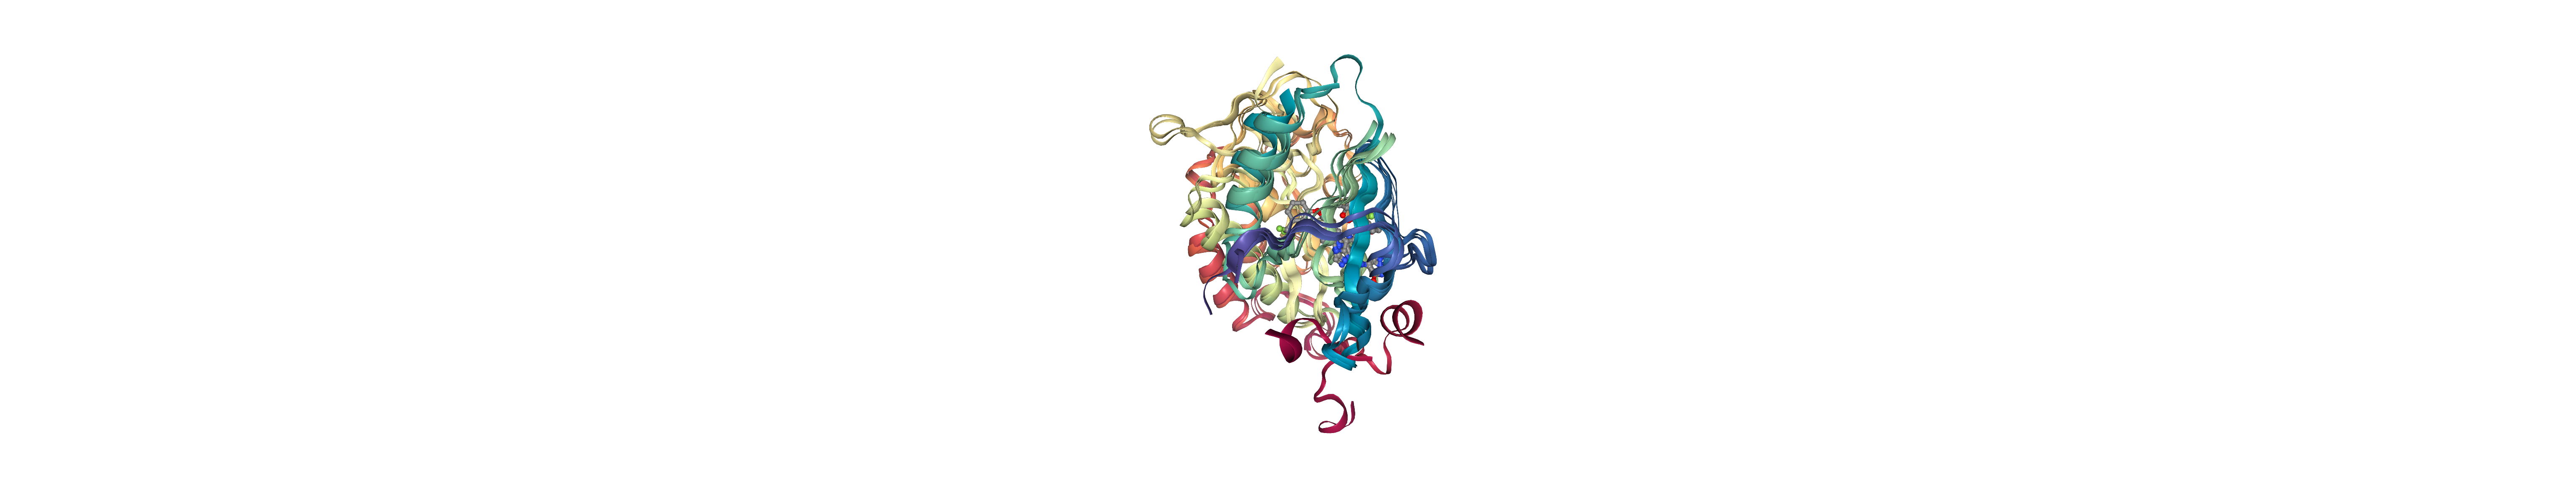

In [31]:
v._display_image()

#### 4. Extract ligands 

In [32]:
ligands = [Structure.from_atomgroup(complex.select_atoms(f"resname {ligand}")) for complex, ligand in zip(complexes, pairs.values())]
ligands

/home/jaime/.conda/envs/teachopencadd-ci/lib/python3.8/site-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array(sorted(unique_bonds)), 4)


[<Universe with 32 atoms>,
 <Universe with 28 atoms>,
 <Universe with 30 atoms>,
 <Universe with 38 atoms>]

In [33]:
for ligand, pdb_id in zip(ligands, pairs.keys()):
    ligand.write(f"./data/{pdb_id}_lig.pdb")

/home/jaime/.conda/envs/teachopencadd-ci/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:722: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/home/jaime/.conda/envs/teachopencadd-ci/lib/python3.8/site-packages/MDAnalysis/coordinates/PDB.py:1026: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  warnings.warn("Found no information for attr: '{}'"


We check the existence of all ligand *pdb* files.

In [34]:
mol_files = []
for file in glob.glob("./data/*_lig.pdb"):
    mol_files.append(file)
mol_files

['./data/5UG9_lig.pdb',
 './data/5UG8_lig.pdb',
 './data/5HG8_lig.pdb',
 './data/3POZ_lig.pdb']

In [35]:
v = nglview.NGLWidget()

ligand_colors = {0: 'magenta', 1: 'cyan', 2: 'yellow', 3: 'grey'}

for component_id, ligand in enumerate(ligands):
    v.add_component(ligand.atoms)
    v.remove_ball_and_stick(component=component_id)
    v.add_licorice(component=component_id, colorScheme="element", colorValue=ligand_colors[component_id])
v

NGLWidget()

In [36]:
v.render_image();

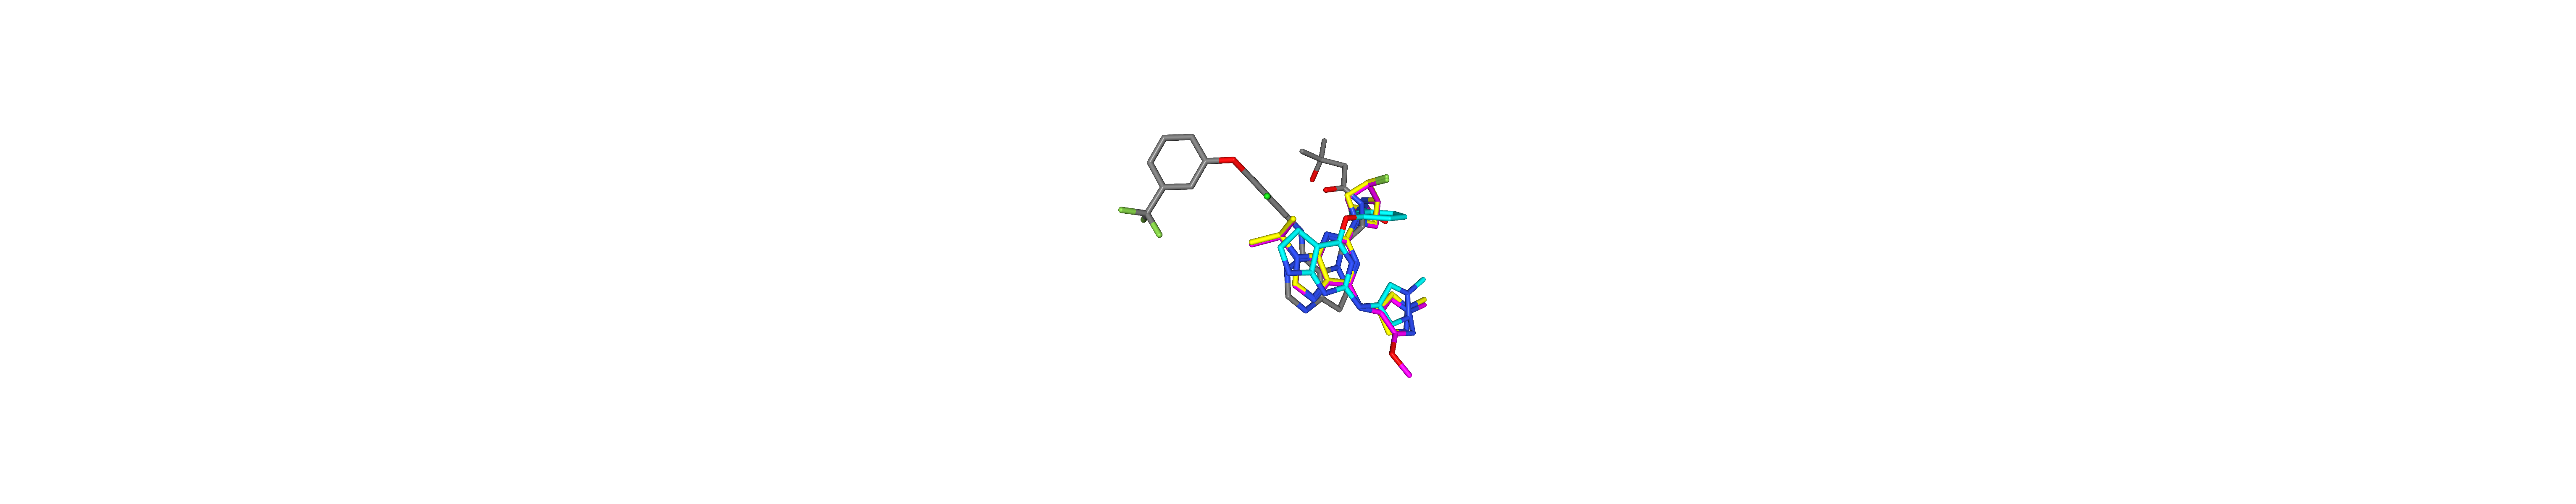

In [37]:
v._display_image()

## Discussion

In this talktorial, we learned how to retrieve protein and ligand meta information and structural information from the PDB. We retained only X-ray structures and filtered our data by resolution and ligand availability. Ultimately, we aimed for an aligned set of ligands to be used in the next talktorial for the generation of ligand-based ensemble pharmacophores. 

In order to enrich information about ligands for pharmacophore modeling, it is advisable to not only filter by PDB structure resolution, but also to check for ligand diversity (see **talktorial 5** on molecule clustering by similarity) and to check for ligand activity (i.e. to include only potent ligands). 

## Quiz

1. Summarize the kind of data that the Protein Data Bank contains.
2. Explain what the resolution of a structure stands for and how and why we filter for it in this talktorial.
3. Explain what an alignment of structures means and discuss the alignment performed in this talktorial.